# Import Libraries

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from statsmodels.graphics.tsaplots import month_plot,quarter_plot,plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from prophet.models import StanBackendEnum
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_log_error
from prophet import Prophet


# Load the Datasets
We load all the required datasets.
For columns that represent dates (e.g., date), we use parse_dates=["date"] when reading the files to automatically convert them into datetime64 objects. This makes time-based operations much easier more convenient for time series analysis.

In [79]:
train = pd.read_csv("train.csv", parse_dates=["date"])
test = pd.read_csv("test.csv", parse_dates=["date"])
stores = pd.read_csv("stores.csv")
transactions = pd.read_csv("transactions.csv", parse_dates=["date"])
holidays = pd.read_csv("holidays_events.csv", parse_dates=["date"])
holidays=holidays[holidays["transferred"]==False]
oil = pd.read_csv("oil.csv", parse_dates=["date"])

# Merge Auxiliary Data into df

- **stores.csv** → Adds store information (city, state, type, cluster).

- **transactions.csv** → Adds daily transactions per store.

- **oil.csv** → Adds oil prices (missing values forward-filled).

- **holidays_events.csv** → Adds holiday/event type for each date.

## Merge Auxiliary Data into DataFrame

- Merge datasets (on store_nbr, left join)
- Merge datasets (on [date,store_nbr], left join)
- Merge datasets (on date, left join)
- Merge datasets (on date, left join)
- Handle missing values (e.g., forward-fill)


In [80]:
df = train.merge(stores, on="store_nbr", how="left")
df = df.merge(transactions, on=["date", "store_nbr"], how="left")
oil["dcoilwtico"] = oil["dcoilwtico"].fillna(method="ffill")
df = df.merge(oil, on="date", how="left")
df = df.merge(holidays[["date","type"]], on="date", how="left")

C:\Users\MOSTAFA\AppData\Local\Temp\ipykernel_20136\3285973314.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil["dcoilwtico"] = oil["dcoilwtico"].fillna(method="ffill")


## Remove Duplicate

In [81]:
initial_rows = df.shape[0]
df = df.drop_duplicates()
print(f"Removed {initial_rows - df.shape[0]} duplicate rows.")
df.shape

Removed 30294 duplicate rows.


(3024054, 13)

## Fill Missing values in type_y

## Clean and Preprocess Data

- Impute missing values


In [82]:
df['type_y'] = df['type_y'].fillna('Work Day')

## Average Sales per day_type

In [83]:
df.groupby("type_y", as_index=False)["sales"].mean().sort_values("sales", ascending=False)

,type_y,sales
0,Additional,487.628925
4,Transfer,467.753110
1,Bridge,446.750854
2,Event,425.024432
3,Holiday,359.138598
5,Work Day,351.975641


## Handle Duplicated  in Holidays Events

In [84]:
holiday_priority ={
    'Holiday': 2,
    'Bridge': 4,
    'Transfer': 5,
    'Additional': 6,
    'Work Day': 1,
    'Event': 3
}

In [85]:
holidays["priority"] = holidays["type"].map(holiday_priority)
idx=holidays.groupby("date")["priority"].idxmax()
holidays=holidays.loc[idx].reset_index(drop=True)

# Merge Auxiliary Data into Train

- **stores.csv** → Adds store information (city, state, type, cluster).

- **transactions.csv** → Adds daily transactions per store.

- **oil.csv** → Adds oil prices (missing values forward-filled).

- **holidays_events.csv** → Adds holiday/event type for each date.

## Merge Auxiliary Data into DataFrame

- Merge datasets (on store_nbr, left join)
- Merge datasets (on [date,store_nbr], left join)
- Merge datasets (on date, left join)
- Merge datasets (on date, left join)
- Handle missing values (e.g., forward-fill)


In [86]:
train = train.merge(stores, on="store_nbr", how="left")
train = train.merge(transactions, on=["date", "store_nbr"], how="left")
oil["dcoilwtico"] = oil["dcoilwtico"].fillna(method="ffill")
train = train.merge(oil, on="date", how="left")
train = train.merge(holidays[["date","type"]], on="date", how="left")

C:\Users\MOSTAFA\AppData\Local\Temp\ipykernel_20136\1920280977.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil["dcoilwtico"] = oil["dcoilwtico"].fillna(method="ffill")


In [87]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday


### Renaming Columns for Clarity

- After merging multiple datasets, some columns inherited generic names like `type_x` and `type_y`.  
- To make the dataset more interpretable, we renamed them:

    - **type_x** (coming from stores.csv) →  **store_type**

        Indicates the type of store (A, B, C, or D).

    - **type_y** (coming from holidays_events.csv) → **day_type**

        Classifies each date as either a special event (Holiday, Transfer, Additional, Event, etc.) or a regular Work Day (for dates without special events).

## Clean and Preprocess Data


In [88]:
train = train.rename(columns={
    'type_x': 'store_type',
    'type_y': 'day_type'
})

# Merge Auxiliary Data into Test

- **stores.csv** → Adds store-level information (`city`, `state`, `type`, `cluster`).  

- **transactions.csv** → Adds the number of daily transactions for each store (based on `date` + `store_nbr`).  

- **oil.csv** → Adds oil price (`dcoilwtico`) for each date.  

- **holidays_events.csv** → Adds holiday/event type (`type`) for each date.  

**Note**: Unlike the train dataset, the test dataset does not include the `sales` column, because `sales` is the target variable we aim to predict. All other auxiliary data is merged to provide the necessary context for forecasting.  


## Merge Auxiliary Data into DataFrame

- Merge datasets (on store_nbr, left join)
- Merge datasets (on [date,store_nbr], left join)
- Merge datasets (on date, left join)
- Merge datasets (on date, left join)


In [89]:
test = test.merge(stores, on="store_nbr", how="left")
test = test.merge(transactions, on=["date", "store_nbr"], how="left")
test = test.merge(oil, on="date", how="left")
test = test.merge(holidays[["date","type"]], on="date", how="left")
test.head()

,id,date,store_nbr,family,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NaN,46.8,NaN
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,NaN,46.8,NaN
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,NaN,46.8,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,NaN,46.8,NaN
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,NaN,46.8,NaN


### Renaming Columns for Clarity (Test Set)

- Similar to the train dataset, merging multiple files created generic column names (`type_x`, `type_y`).  
- To make the test dataset more interpretable, we renamed them:

    - **type_x** (from `stores.csv`) → **store_type**  
      Indicates the type of store (A, B, C, or D).  

    - **type_y** (from `holidays_events.csv`) → **day_type**  
      Classifies each date as either a special event (Holiday, Transfer, Additional, Event, etc.) or a regular Work Day (for dates without special events).  


## Clean and Preprocess Data


In [90]:
test = test.rename(columns={
    'type_x': 'store_type',
    'type_y': 'day_type'
})

# **Dataset Overview**

## Shape of the dataset

In [91]:
train.shape

(3000888, 13)

In [92]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,dcoilwtico,day_type
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday


## Dataset info (data types + missing values)

In [93]:
train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   id            3000888 non-null  int64         
 1   date          3000888 non-null  datetime64[ns]
 2   store_nbr     3000888 non-null  int64         
 3   family        3000888 non-null  object        
 4   sales         3000888 non-null  float64       
 5   onpromotion   3000888 non-null  int64         
 6   city          3000888 non-null  object        
 7   state         3000888 non-null  object        
 8   store_type    3000888 non-null  object        
 9   cluster       3000888 non-null  int64         
 10  transactions  2755104 non-null  float64       
 11  dcoilwtico    2141964 non-null  float64       
 12  day_type      433026 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 297.6+ MB


## Missing values count

In [94]:
train.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
transactions     245784
dcoilwtico       858924
day_type        2567862
dtype: int64

**Columns with Missing Values**  
   - **`transactions` → 249,117 missing (~8.2%)**  
     - Not all stores have transaction logs available.  
     - Missing values can be imputed using median per store or interpolation.  

   - **`dcoilwtico` → 880,308 missing (~28.8%)**  
     - Oil prices are not recorded on weekends and holidays (markets closed).  
     - We can fix it using forward-fill (`ffill`) or interpolation.  

   - **`day_type` → 2,551,824 missing (~83.5%)**  
     - Represents holiday/event types.  
     - Missing values simply mean “regular work day.”  
     - Can safely replace NaN with `"Work Day"`.  

#### Key Takeaways
- Core dataset is very clean (no missing values in essential features like `sales`, `date`, `store_nbr`).  
- Missing values are expected in auxiliary features (transactions, oil prices, holidays).  

In [95]:
test.isna().sum()

id                  0
date                0
store_nbr           0
family              0
onpromotion         0
city                0
state               0
store_type          0
cluster             0
transactions    28512
dcoilwtico       7128
day_type        26730
dtype: int64

## **Columns with Missing Values — Test Dataset**

- **`transactions` → 28,512 missing (100%)**  
  - All transaction values are missing in the test set.  
  - Since this feature is not available for prediction, we will drop the `transactions` column from both **train** and **test** to keep the datasets aligned.  

- **`dcoilwtico` → 7,128 missing (~2.4%)**  
  - Oil prices are not recorded on weekends and holidays (markets closed).  
  - We can handle missing values using **forward-fill (`ffill`)**.  

- **`day_type` → 26,730 missing (~9.0%)**  
  - Represents holiday/event types.  
  - Missing values simply mean “regular work day.”  
  - We can safely replace NaN with `"Work Day"`.  


## Check duplicates

In [96]:
train.duplicated().sum()

np.int64(0)

In [97]:
test.duplicated().sum()

np.int64(0)

In [98]:
initial_rows = train.shape[0]
train = train.drop_duplicates()
print(f"Removed {initial_rows - train.shape[0]} duplicate rows.")
train.shape

Removed 0 duplicate rows.


(3000888, 13)

**We removed all duplicate rows to ensure data consistency:**  

## Data Validation & Cleaning Checks

## Handle missing values
- Logical imputation strategies:  
  - `transactions`: median per store.  
  - `dcoilwtico`: forward-fill.  
  - `day_type`: fill NaN with `"Work Day"`.  

**Fill missing values of dcoilwtico column with forward-fill then back-fill for any leading NaNs**

## Clean and Preprocess Data

- Impute missing values


In [99]:
train['dcoilwtico'] = train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

C:\Users\MOSTAFA\AppData\Local\Temp\ipykernel_20136\1575899407.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['dcoilwtico'] = train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


**Fill missing values day_type column with "Work Day"**

## Clean and Preprocess Data

- Impute missing values


In [100]:
train['day_type'] = train['day_type'].fillna('Work Day')

In [101]:
train.isnull().sum()


id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
store_type           0
cluster              0
transactions    245784
dcoilwtico           0
day_type             0
dtype: int64

**Fill missing values of dcoilwtico column in the test dataset with forward-fill then back-fill for any leading NaNs**

## Clean and Preprocess Data

- Impute missing values


In [102]:
test['dcoilwtico'] = test['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

C:\Users\MOSTAFA\AppData\Local\Temp\ipykernel_20136\706933418.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test['dcoilwtico'] = test['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


**Fill missing values day_type column in the test dataset with "Work Day"**

## Clean and Preprocess Data

- Impute missing values


In [103]:
test['day_type'] = test['day_type'].fillna('Work Day')

## **Dropping the `transactions` Column**

To keep the datasets consistent, we drop `transactions` from both **train** and **test**:

In [104]:
train.drop("transactions",axis=1,inplace=True)

In [105]:
test.drop("transactions",axis=1,inplace=True)

In [106]:
train.shape

(3000888, 12)

In [107]:
train['date'] = pd.to_datetime(train['date'])
train.set_index("date",inplace=True)
test.set_index("date",inplace=True)

## Check data types

In [108]:
train.dtypes

id               int64
store_nbr        int64
family          object
sales          float64
onpromotion      int64
city            object
state           object
store_type      object
cluster          int64
dcoilwtico     float64
day_type        object
dtype: object

- **Categorical Columns:** family, city, state, store_type, day_type.  
- **Numeric Columns:** id, store_nbr, sales, onpromotion, cluster, transactions, dcoilwtico.  
- **Datetime Columns:** date.


## List of all columns

In [109]:
train.columns

Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state',
       'store_type', 'cluster', 'dcoilwtico', 'day_type'],
      dtype='object')

## Unique values exploration

**View all distinct product families available in the dataset.**

In [110]:
train.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

**Get unique store types in the dataset**

In [111]:
train.store_type.unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

**Get unique day types in the dataset**

In [112]:
train.day_type.unique()

array(['Holiday', 'Work Day', 'Additional', 'Event', 'Transfer', 'Bridge'],
      dtype=object)

## Count unique values in each column

In [113]:
train.nunique()

id             3000888
store_nbr           54
family              33
sales           379610
onpromotion        362
city                22
state               16
store_type           5
cluster             17
dcoilwtico         994
day_type             6
dtype: int64

## Store Network Structure
- **54 stores** across **22 cities** and **16 states**
- Average of ~2.45 stores per city
- **17 clusters** for geographic or performance grouping
- **5 store types** (A, B, C, D, E) indicating different formats or tiers

## Temporal Coverage
- **1,684 days** of data ≈ **4.6 years** of daily records
- **6 day types** (including Work Day, Holiday, Work Day, Additional, Event, Transfer, Bridge)

## Product & Sales Diversity
- **33 product families** offering diverse category analysis
- **379,610 unique sales values** showing high variability
- **362 promotion levels** indicating varied promotional intensity
- **4,993 transaction count variations** suggesting different store sizes

## Data Quality Indicators
- **3M+ records** with unique IDs - comprehensive dataset
- **994 oil price points** - good external economic indicator coverage

## Descriptive statistics for all columns

In [114]:
train.describe(include='all')

,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,day_type
count,3.000888e+06,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3000888,3000888,3000888,3.000888e+06,3.000888e+06,3000888
unique,NaN,NaN,33,NaN,NaN,22,16,5,NaN,NaN,6
top,NaN,NaN,AUTOMOTIVE,NaN,NaN,Quito,Pichincha,D,NaN,NaN,Work Day
freq,NaN,NaN,90936,NaN,NaN,1000296,1055868,1000296,NaN,NaN,2574990
mean,1.500444e+06,2.750000e+01,NaN,3.577757e+02,2.602770e+00,NaN,NaN,NaN,8.481481e+00,6.792490e+01,NaN
std,8.662819e+05,1.558579e+01,NaN,1.101998e+03,1.221888e+01,NaN,NaN,NaN,4.649735e+00,2.566913e+01,NaN
min,0.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,1.000000e+00,2.619000e+01,NaN
25%,7.502218e+05,1.400000e+01,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,4.000000e+00,4.637750e+01,NaN
50%,1.500444e+06,2.750000e+01,NaN,1.100000e+01,0.000000e+00,NaN,NaN,NaN,8.500000e+00,5.341000e+01,NaN
75%,2.250665e+06,4.100000e+01,NaN,1.958473e+02,0.000000e+00,NaN,NaN,NaN,1.300000e+01,9.572000e+01,NaN


# Dataset Statistical Summary

### Date
- **Range**: 2013-01-01 → 2017-08-15  
- **Median**: April 26, 2015 → balanced 4.6-year coverage  
- **Temporal spread**: Evenly distributed across the period

### Store Number
- **Range**: Store 1 → Store 54  
- **Mean**: 27.5 → stores evenly distributed numerically  
- **Std**: 15.6 → good spread across store IDs

### Product Family
- **33 unique categories**  
- **Most frequent**: **Automotive** (91,638 entries)  
- Dominant category suggests focus on automotive products

### Sales
- **Range**: $0 → $124,717
  
- **Median**: $11  →  highly right-skewed distribution

  
- **Mean**:  $358.78 (vs Median $11) → extreme outliers present

  
- **Std**: $1,106.76 → very high variability

### On Promotion
- **Range**: 0 → 741 items  
- **Mean**: 2.61 items promoted  
- **75% records**: 0 promotions → sparse promotional activity  
- **Std**: 12.26 → high variation in promotion intensity

### Geography
- **22 cities** → **Top: Quito** (1,008,018 entries)  
- **16 states** → **Top: Pichincha** (1,064,019 entries)  
- Geographic concentration in specific areas

### Store Type
- **5 store types** → **Most frequent: Type D** (1,008,018 entries)  
- Type D dominates the network

### Cluster
- **17 clusters** → Range: 1-17  
- **Mean**: 8.48 → balanced cluster distribution  
- **Std**: 4.65 → moderate variation in cluster sizes

### Transactions
- **Range**: 5 → 8,359 transactions  
- **Median**: 1,395 → right-skewed distribution  
- **Mean**: 1,673 → larger stores pull average up  
- **Std**: 930.65 → significant store size variation

### Oil Price (dcoilwtico)
- **Range**: $26.19 → $110.62  
- **Median**: $53.41 (vs Mean $67.86) → left-skewed distribution  
- **Std**: $25.66 → high volatility in oil prices

### Day Type
- **6 unique day types**  
- **Most frequent**: **Work Day** (2,560,734 entries)  
- Balanced representation of different day types

## Add Feature Engineering

To enhance our dataset with time-related insights, we extract several features from the `date` column.  
This helps capture seasonal patterns, monthly trends, and weekday effects in sales forecasting.

In [115]:
train["Day"]=train.index.day
train["Week_day"]=train.index.strftime("%A")
train['Weekend'] = train["Week_day"].apply(lambda x: 'Weekend' if x in ['Saturday','Sunday'] else 'Weekday')

In [116]:
test["Day"]=test.index.day
test["Week_day"]=test.index.strftime("%A")
test['Weekend'] = test["Week_day"].apply(lambda x: 'Weekend' if x in ['Saturday','Sunday'] else 'Weekday')

In [117]:
df = train['sales']
df = df.resample('D').sum().asfreq('D')
df

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Freq: D, Name: sales, Length: 1688, dtype: float64

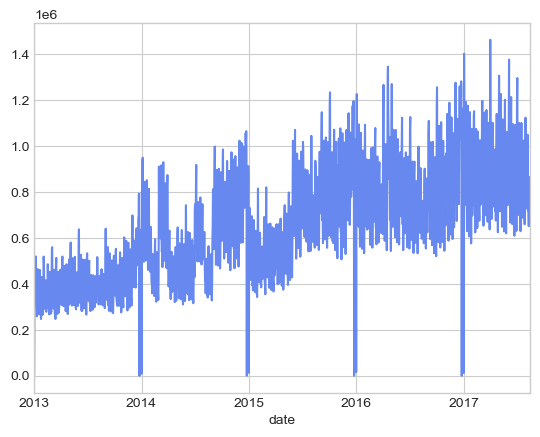

In [118]:
df=pd.DataFrame(df)
df.sales.plot()
plt.show()



C:\Users\MOSTAFA\AppData\Local\Temp\ipykernel_20136\395860107.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_plot(df['sales'].resample('M').mean(),


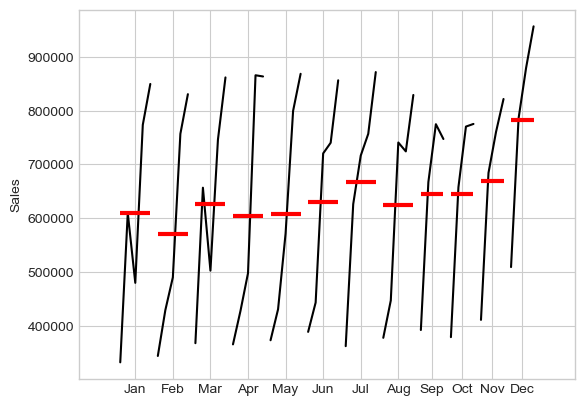

In [119]:
month_plot(df['sales'].resample('M').mean(),
           ylabel = 'Sales')
plt.show()

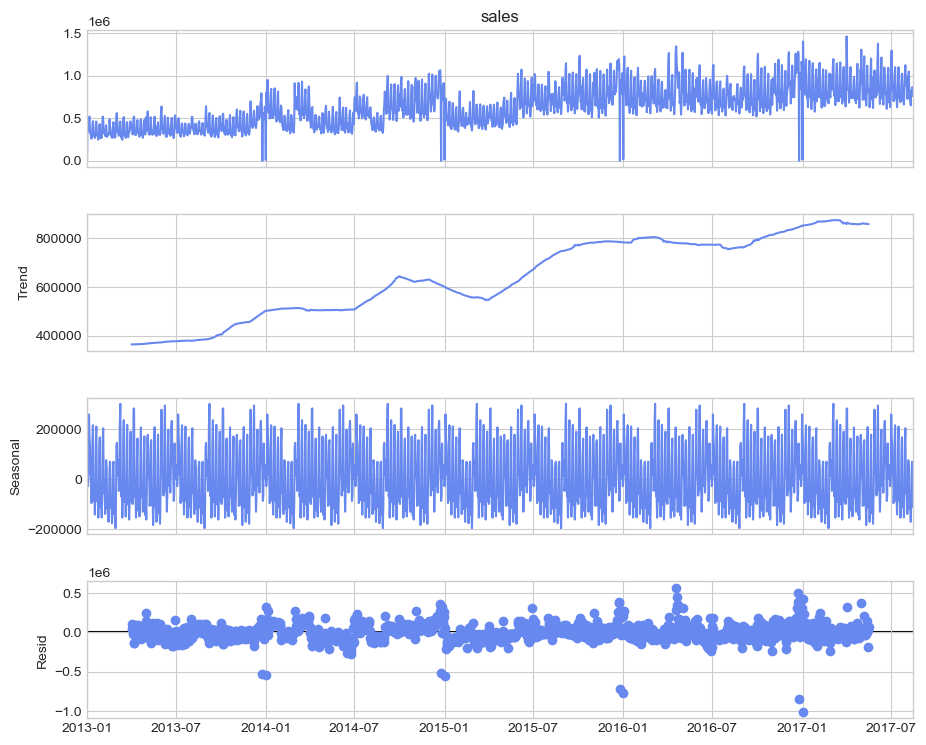

In [120]:
decomposition = seasonal_decompose(df['sales'],
                                   model = 'add',
                                   period = 182)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

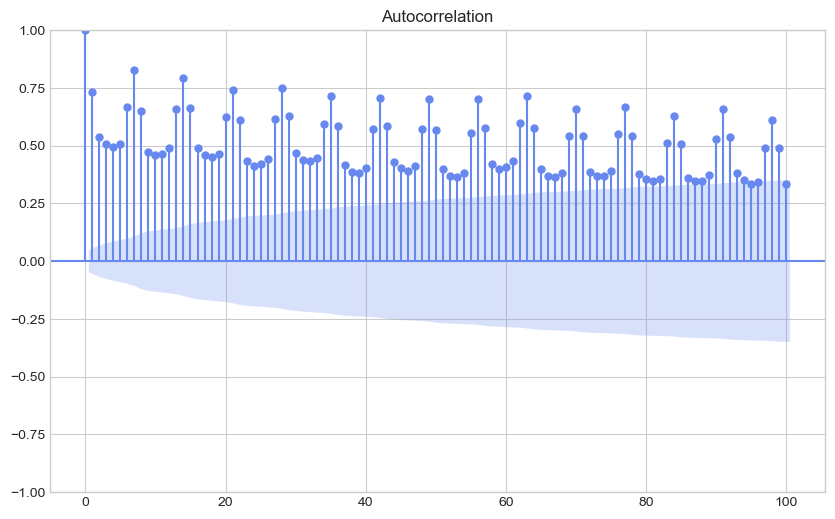

In [121]:
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['sales'], lags = 100, ax = ax)
plt.show()

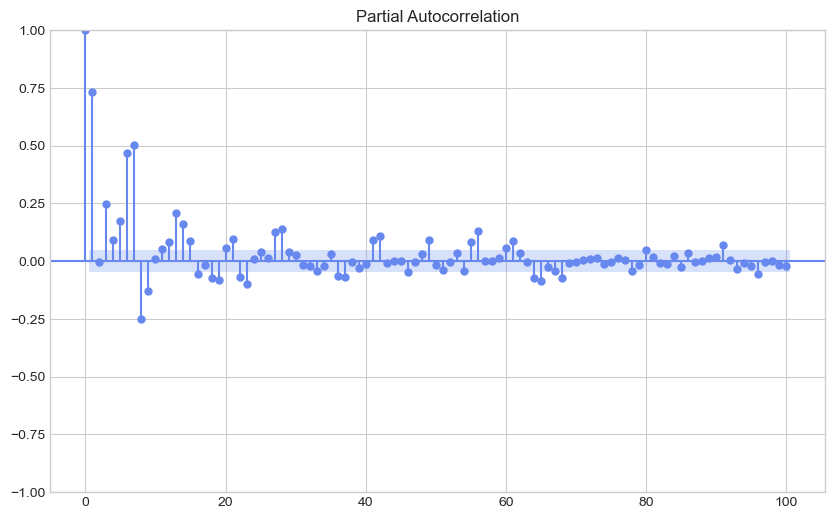

In [122]:
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['sales'], lags = 100, ax = ax)
plt.show()

In [123]:
result = adfuller(df.sales)
print(f"p-value: {result[1]}")

if result[1] > 0.05:
  print("The time series is not stationary")
else:
  print("The time series is stationary")

p-value: 0.0990505835248422
The time series is not stationary


In [124]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [125]:
train.reset_index(inplace=True)

In [126]:
test.reset_index(inplace=True)

In [127]:
train = train.rename(columns={'date': 'ds', 'sales': 'y'})

train['ds'] = pd.to_datetime(train['ds'])
years=train['ds'].dt.year.unique()
holiday_dates = [f"{y}-12-25" for y in years]
holidays = pd.DataFrame({
    'holiday': 'christmas_25_dec',
    'ds': pd.to_datetime(holiday_dates),
    'lower_window': 0,
    'upper_window': 0
})

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive',
    holidays=holidays
)
model.fit(train)

In [128]:
train

,ds,y
0,2013-01-01,2.511619e+03
1,2013-01-02,4.960924e+05
2,2013-01-03,3.614612e+05
3,2013-01-04,3.544597e+05
4,2013-01-05,4.773501e+05
...,...,...
1345,2016-09-07,7.385439e+05
1346,2016-09-08,5.958493e+05
1347,2016-09-09,6.589690e+05
1348,2016-09-10,9.159386e+05


             ds           yhat     yhat_lower    yhat_upper
1683 2017-08-11  716621.667872  575801.441360  8.577875e+05
1684 2017-08-12  902790.075279  749293.649094  1.042396e+06
1685 2017-08-13  954656.065014  812890.212176  1.088948e+06
1686 2017-08-14  759682.236836  616832.125137  9.028551e+05
1687 2017-08-15  716285.674655  576243.519932  8.347103e+05


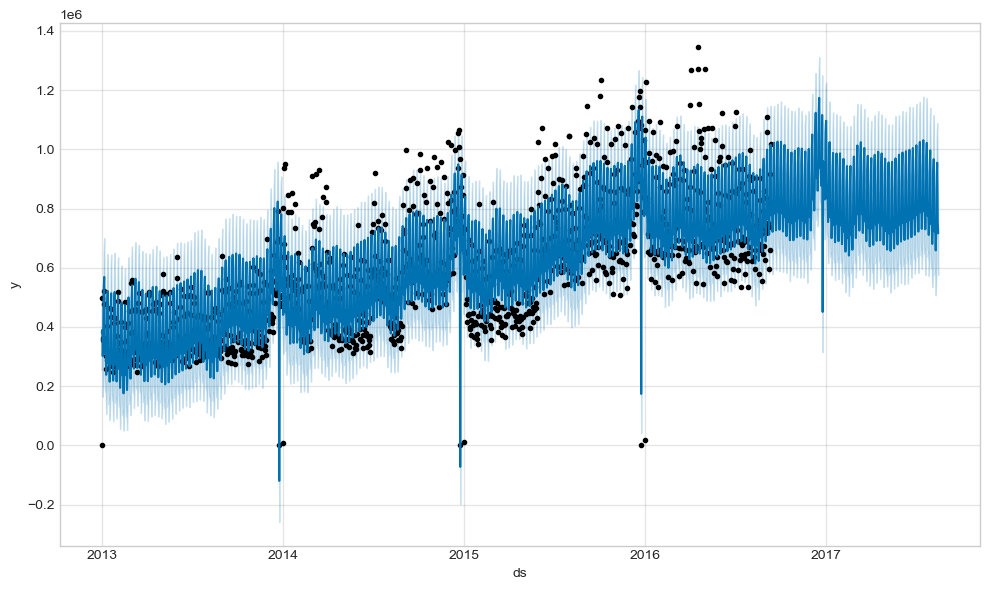

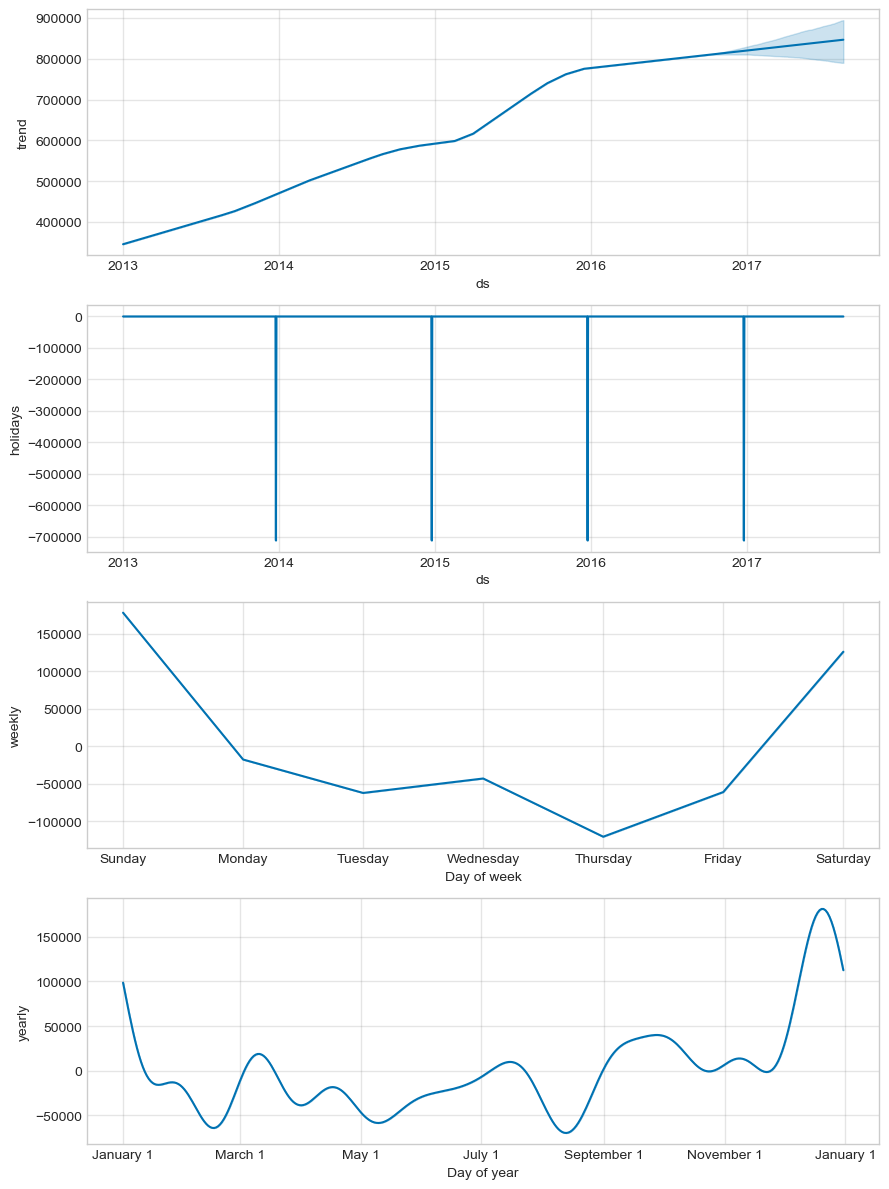

In [129]:
future = model.make_future_dataframe(periods=len(test))

forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

model.plot(forecast)
plt.show()

model.plot_components(forecast)
plt.show()

In [130]:
test = test.rename(columns={'date': 'ds', 'sales': 'y'})
test['ds'] = pd.to_datetime(test['ds'])

In [131]:
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)
y_pred = forecast['yhat'].iloc[-len(test):].values
y_true = test['y'].values

mae = np.mean(np.abs(y_true - y_pred))
rmse = np.sqrt(np.mean((y_true - y_pred)**2))

mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
rmse_pct = (rmse / np.mean(y_true)) * 100


print(f"MAE (original scale): {mae:.2f}")
print(f"RMSE (original scale): {rmse:.2f}")
print(f"RMSE (% of mean): {rmse_pct:.2f}%")


MAE (original scale): 89758.84
RMSE (original scale): 133231.05
RMSE (% of mean): 15.76%


C:\Users\MOSTAFA\AppData\Local\Temp\ipykernel_20136\1554931830.py:9: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100


In [132]:
print(mae*100/np.mean(y_true))

10.617774576584177


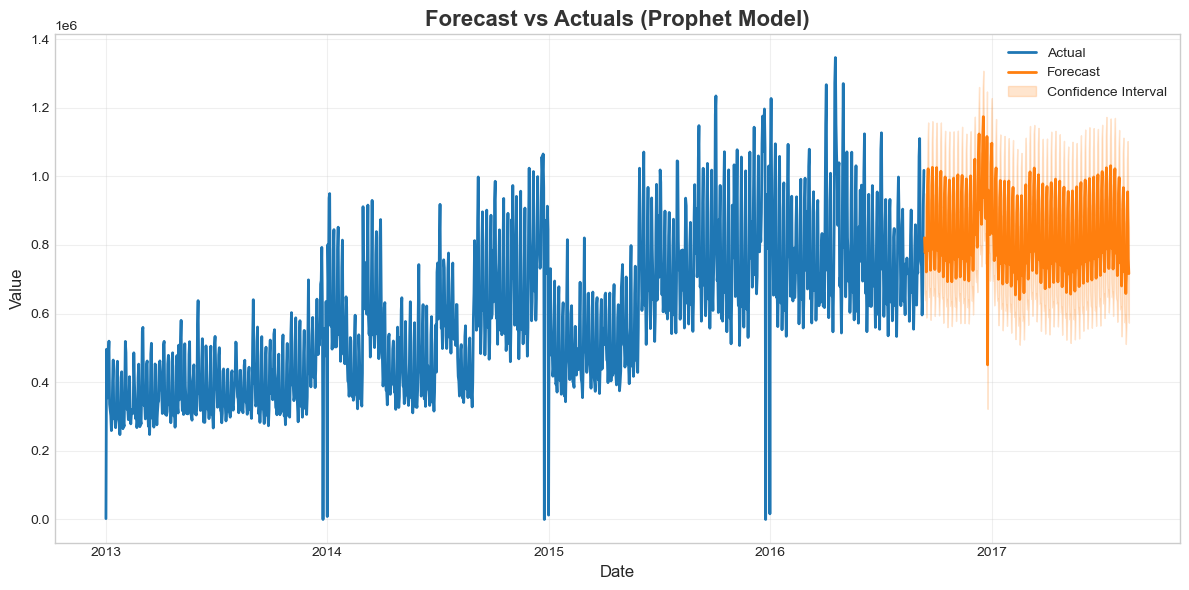

In [133]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('coolwarm')

plt.figure(figsize=(12,6))
plt.plot(model.history['ds'], model.history['y'], label='Actual', color='#1f77b4', linewidth=2)
plt.plot(forecast['ds'].iloc[-len(test):], forecast['yhat'].iloc[-len(test):], label='Forecast', color='#ff7f0e', linewidth=2)

plt.fill_between(
    forecast['ds'].iloc[-len(test):],
    forecast['yhat_lower'].iloc[-len(test):],
    forecast['yhat_upper'].iloc[-len(test):],
    color='#ff7f0e',
    alpha=0.2,
    label='Confidence Interval'
)

plt.title('Forecast vs Actuals (Prophet Model)', fontsize=16, fontweight='bold', color='#333')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

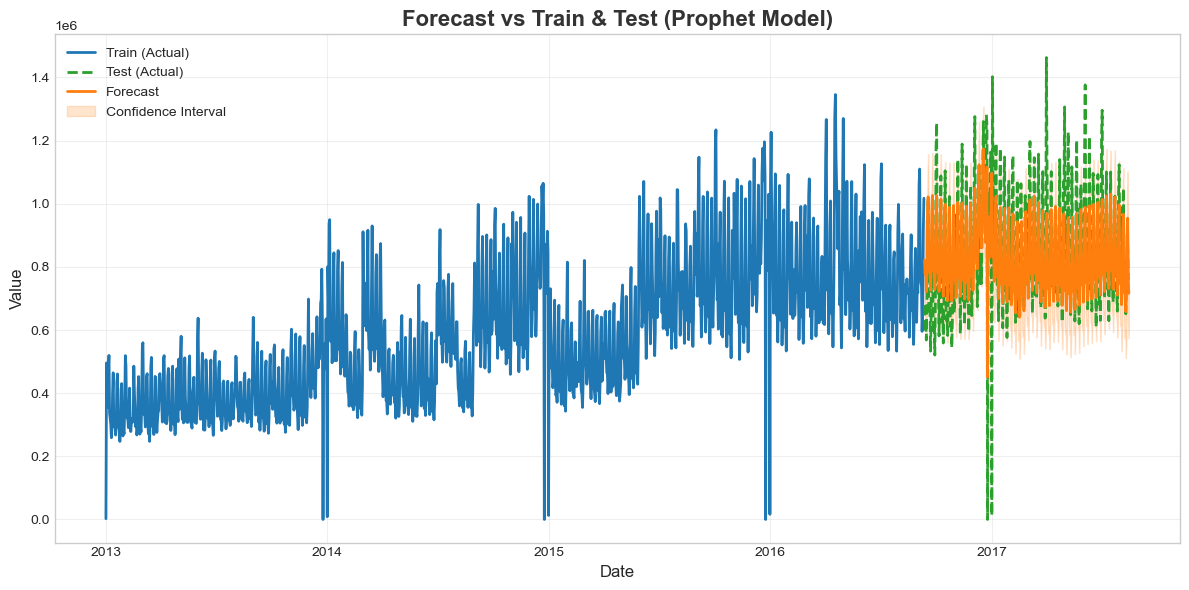

In [134]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('coolwarm')

plt.figure(figsize=(12,6))

plt.plot(model.history['ds'], model.history['y'],
         label='Train (Actual)', color='#1f77b4', linewidth=2)

plt.plot(test['ds'], test['y'],
         label='Test (Actual)', color='#2ca02c', linewidth=2, linestyle='--')

plt.plot(forecast['ds'].iloc[-len(test):], forecast['yhat'].iloc[-len(test):],
         label='Forecast', color='#ff7f0e', linewidth=2)

plt.fill_between(
    forecast['ds'].iloc[-len(test):],
    forecast['yhat_lower'].iloc[-len(test):],
    forecast['yhat_upper'].iloc[-len(test):],
    color='#ff7f0e',
    alpha=0.2,
    label='Confidence Interval'
)

plt.title('Forecast vs Train & Test (Prophet Model)', fontsize=16, fontweight='bold', color='#333')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Hyperparameter tuning

### Subtask:
Tune the Prophet model's hyperparameters (e.g., `changepoint_prior_scale`, `seasonality_prior_scale`, `holidays_prior_scale`) to find a better configuration.

**Reasoning**:
Import necessary libraries for hyperparameter tuning and Prophet model.

In [135]:
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

**Reasoning**:
Define a parameter grid and iterate through it to train and evaluate Prophet models with different hyperparameters.

In [136]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.1, 1.0, 10.0]
}

best_rmse = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        seasonality_mode='additive',
        holidays=holidays,
        **params
    )

    model.fit(train)

    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)

    y_true = test['y'].values
    y_pred = forecast['yhat'].iloc[-len(test):].values

    rmse = np.sqrt(np.mean((y_true - y_pred)**2))

    print(f"RMSE: {rmse:.2f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print(f"\nBest RMSE: {best_rmse:.2f}")
print(f"Best parameters: {best_params}")

Training with parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}
RMSE: 165755.32
Training with parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}
RMSE: 160645.69
Training with parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}
RMSE: 153744.03
Training with parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}
RMSE: 156120.25
Training with parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}
RMSE: 152255.08
Training with parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10.0}
RMSE: 156431.07
Training with parameters: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10.0, 'seasonality_prior_scale': 0.1}
RMSE: 156078.17
Training with parameters: {'cha

**Reasoning**:
The columns are already named 'ds' and 'y' in the `train` DataFrame. Now, prepare the test data for Prophet by selecting and renaming columns.

## Model training

### Subtask:
Train the Prophet model with the best hyperparameters found during the tuning process on the training data.

In [159]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='additive',
    holidays=holidays,
    **best_params
)
model.fit(train)

In [160]:
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

In [161]:
y_true = test['y'].values
y_pred = forecast['yhat'].iloc[-len(test):].values

mae = np.mean(np.abs(y_true - y_pred))
rmse = np.sqrt(np.mean((y_true - y_pred)**2))

mask = y_true != 0
mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print('MAE%', mae*100/np.mean(y_true))

MAE: 88709.83
RMSE: 133092.31
MAE% 10.493684522254036


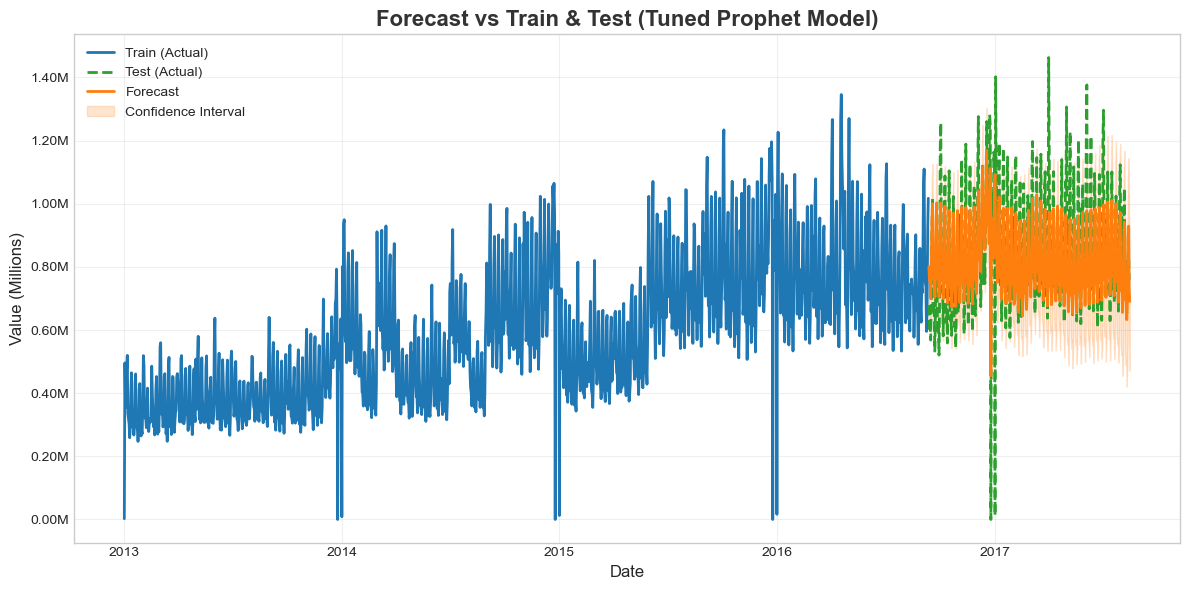

In [149]:
import matplotlib.ticker as ticker

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('coolwarm')

plt.figure(figsize=(12,6))

plt.plot(model.history['ds'], model.history['y'],
         label='Train (Actual)', color='#1f77b4', linewidth=2)

plt.plot(test['ds'], test['y'],
         label='Test (Actual)', color='#2ca02c', linewidth=2, linestyle='--')

plt.plot(forecast['ds'].iloc[-len(test):], forecast['yhat'].iloc[-len(test):],
         label='Forecast', color='#ff7f0e', linewidth=2)

plt.fill_between(
    forecast['ds'].iloc[-len(test):],
    forecast['yhat_lower'].iloc[-len(test):],
    forecast['yhat_upper'].iloc[-len(test):],
    color='#ff7f0e',
    alpha=0.2,
    label='Confidence Interval'
)

plt.title('Forecast vs Train & Test (Tuned Prophet Model)', fontsize=16, fontweight='bold', color='#333')
plt.xlabel('Date', fontsize=12)


plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'{x/1e6:.2f}M')
)
plt.ylabel('Value (Millions)', fontsize=12)

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
